In [1]:
!pip install google-cloud-automl

     |████████████████████████████████| 276 kB 5.4 MB/s eta 0:00:01


In [2]:
import sys
import os
import json
import math

import pandas as pd
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np

from google.cloud import automl
from google.cloud import videointelligence_v1p3beta1 as videointelligence
from google.oauth2 import service_account

In [3]:
project_id = 'qwiklabs-gcp-00-d0d41f801a73'  #@param {type: "string"}
bucket = 'gs://qwiklabs-gcp-00-d0d41f801a73-bucket' #@param {type: "string"}

In [4]:
!gcloud config set project {project_id}
!gsutil mb {bucket}
!gcloud iam service-accounts keys create ./key.json --iam-account {project_id}@{project_id}.iam.gserviceaccount.com

# Enable the Video Intelligence API and AutoML
!gcloud services enable videointelligence.googleapis.com
!gcloud services enable automl.googleapis.com

Updated property [core/project].
Creating gs://qwiklabs-gcp-00-d0d41f801a73-bucket/...
created key [f01a1c8be6d13cd258b6f9d76eca1e66440b94d9] of type [json] as [./key.json] for [qwiklabs-gcp-00-d0d41f801a73@qwiklabs-gcp-00-d0d41f801a73.iam.gserviceaccount.com]
Operation "operations/acf.p2-242812897379-088fd2a5-c2fe-4073-adc8-a616db8b31fa" finished successfully.


In [5]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./key.json"

## Using the Video Intelligence API

<div>
<img src="https://daleonai.com/images/screen-shot-2020-07-14-at-3-45-56-pm.png" width="800"/>
</div>

In [6]:
input_uri = "gs://spls/aiforsports/tennis_serves.mp4"

In [7]:
# This function comes from the docs
# https://cloud.google.com/video-intelligence/docs/people-detection
def detect_person(input_uri):
    """Detects people in a video."""

    client = videointelligence.VideoIntelligenceServiceClient(credentials=service_account.Credentials.from_service_account_file(
    './key.json'))

    # Configure the request
    config = videointelligence.types.PersonDetectionConfig(
        include_bounding_boxes=True,
        include_attributes=True,
        include_pose_landmarks=True,
    )
    context = videointelligence.types.VideoContext(person_detection_config=config)

    # Start the asynchronous request
    operation = client.annotate_video(
        request={
            "features": [videointelligence.Feature.PERSON_DETECTION],
            "input_uri": input_uri,
            "video_context": context,
        }
    )
    
    print("\nProcessing video for person detection annotations.")
    result = operation.result(timeout=300)
    print("\nAnnotation complete!")

    return result


In [8]:
operation = detect_person(input_uri)


Processing video for person detection annotations.

Annotation complete!


In [9]:
# You only care about annotation_results[0] because you only have one video
print(len(operation.annotation_results[0].person_detection_annotations))

6


In [10]:
people_annotations = operation.annotation_results[0].person_detection_annotations

In [11]:
'''
This helper function takes in a person and rearranges the data so it's in 
a timeline, which will make it easier for us to work with
'''
def analyzePerson(person):
  frames = []
  for track in person.tracks:
    # Convert timestamps to seconds
    for ts_obj in track.timestamped_objects:
      time_offset = ts_obj.time_offset
      timestamp = time_offset.seconds + time_offset.microseconds / 1e6
      frame= {'timestamp' : timestamp}
      for landmark in ts_obj.landmarks:
        frame[landmark.name + '_x'] = landmark.point.x
        # Subtract y value from 1 because positions are calculated
        # from the top left corner
        frame[landmark.name + '_y'] = 1 - landmark.point.y
      frames.append(frame)
  sorted(frames, key=lambda x: x['timestamp'])
  return frames

In [12]:
annotationsPd = pd.DataFrame()
for annotation in people_annotations:
  annotationsPd = annotationsPd.append(pd.DataFrame(analyzePerson(annotation)))

annotationsPd = annotationsPd.sort_values('timestamp', ascending=True)

In [13]:
annotationsPd.head()

,timestamp,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,right_ear_x,right_ear_y,left_shoulder_x,...,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,left_ear_x,left_ear_y
0,0.0000,0.249237,0.550769,0.249237,0.555989,0.244341,0.555989,0.233569,0.549028,0.254133,...,0.260009,0.321059,0.226714,0.319319,0.265885,0.244489,0.220838,0.242749,NaN,NaN
1,0.1001,0.249091,0.551092,0.249091,0.556319,0.244188,0.554577,0.233403,0.549349,0.254974,...,0.259877,0.321091,0.226539,0.319348,0.266740,0.244424,0.220656,0.242681,NaN,NaN
2,0.2002,0.249191,0.552001,0.250175,0.558998,0.244269,0.557249,0.234426,0.550252,0.256081,...,0.260018,0.321113,0.226552,0.319364,0.265924,0.244150,0.219662,0.242401,NaN,NaN
3,0.3003,0.250746,0.552638,0.251734,0.559655,0.245811,0.557900,0.235939,0.549129,0.256669,...,0.260618,0.321086,0.226068,0.319332,0.266540,0.243902,0.219158,0.243902,NaN,NaN
4,0.4004,0.252213,0.551864,0.253204,0.558902,0.248253,0.557143,0.237362,0.551864,0.259144,...,0.259144,0.321368,0.225480,0.321368,0.266075,0.243949,0.219539,0.243949,NaN,NaN


## Plotting the Data

<Figure size 432x288 with 0 Axes>

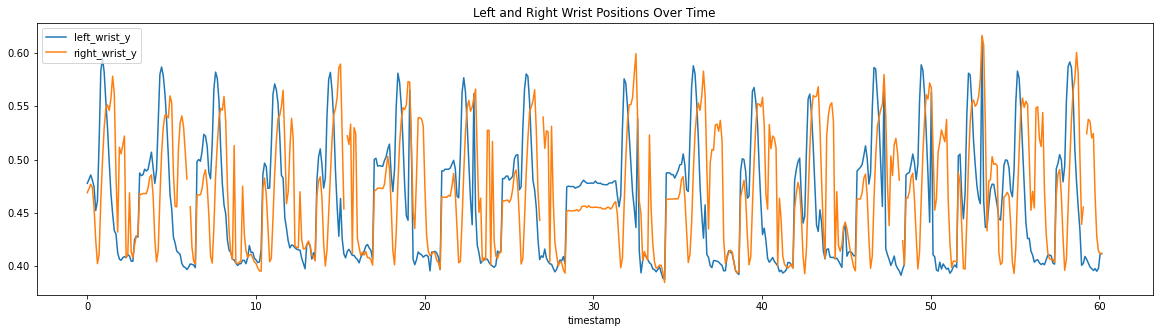

In [14]:
plt.figure()
annotationsPd.plot('timestamp', ['left_wrist_y', 'right_wrist_y'], figsize=(20, 5))
plt.title("Left and Right Wrist Positions Over Time")
plt.savefig("wrist_pos")

## Computing Angles
Step 1: Create some classes for making working with points easier:

In [41]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y 
    
p1 = Point(0,0)
p2 = Point(0,0)

In [16]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c.y-b.y, c.x-b.x) - math.atan2(a.y-b.y, a.x-b.x))
    return ang

In [17]:
def computeElbowAngle(row, which='right'):
  wrist = Point(row[f'{which}_wrist_x'], row[f'{which}_wrist_y'])
  elbow = Point(row[f'{which}_elbow_x'], row[f'{which}_elbow_y'])
  shoulder = Point(row[f'{which}_shoulder_x'], row[f'{which}_shoulder_y'])
  return getAngle(wrist, elbow, shoulder)

def computeShoulderAngle(row, which='right'):
  elbow = Point(row[f'{which}_elbow_x'], row[f'{which}_elbow_y'])
  shoulder = Point(row[f'{which}_shoulder_x'], row[f'{which}_shoulder_y'])
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  return getAngle(hip, shoulder, elbow)

def computeKneeAngle(row, which='right'):
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  knee = Point(row[f'{which}_knee_x'], row[f'{which}_knee_y'])
  ankle = Point(row[f'{which}_ankle_x'], row[f'{which}_ankle_y'])
  return getAngle(ankle, knee, hip)

In [18]:
# For a single timeslot...
row = annotationsPd.iloc[-1]
print("Elbow angle: " + str(computeElbowAngle(row)))
print("Shoulder angle: " + str(computeShoulderAngle(row)))
print("Knee angle: " + str(computeKneeAngle(row)))

Elbow angle: 161.58472316913293
Shoulder angle: 2.14840644195044
Knee angle: 185.3732182302966


In [19]:
annotationsPd['right_elbow_angle'] = annotationsPd.apply(computeElbowAngle, axis=1)
annotationsPd['right_shoulder_angle'] = annotationsPd.apply(computeShoulderAngle, axis=1)
annotationsPd['right_knee_angle'] = annotationsPd.apply(computeKneeAngle, axis=1)

<Figure size 432x288 with 0 Axes>

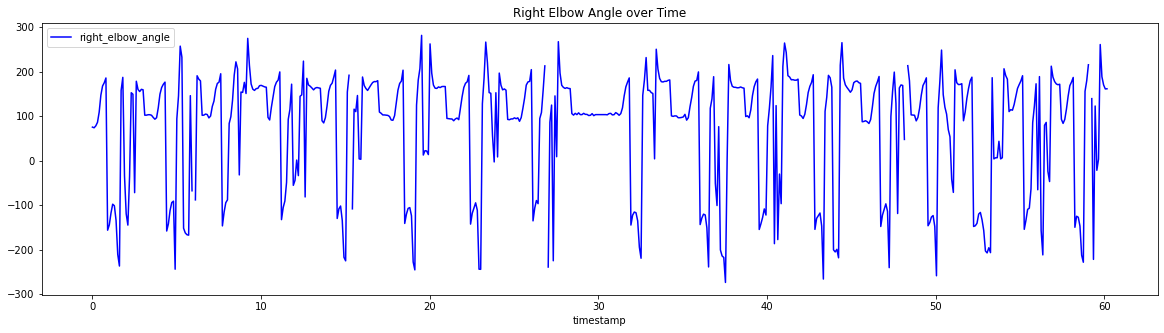

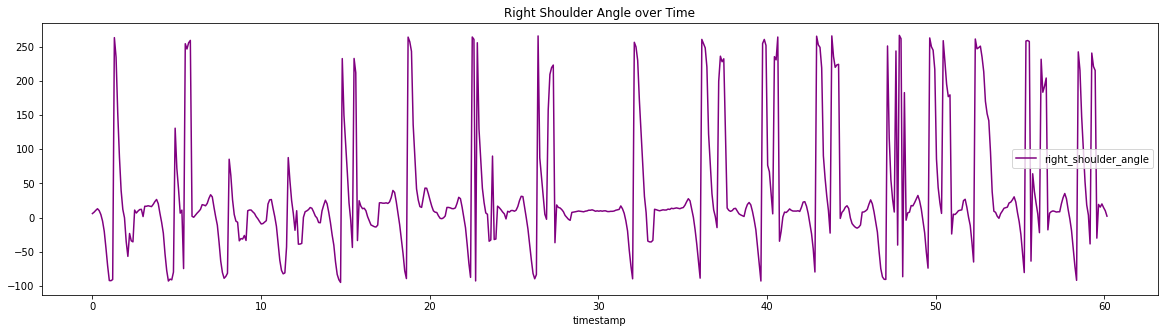

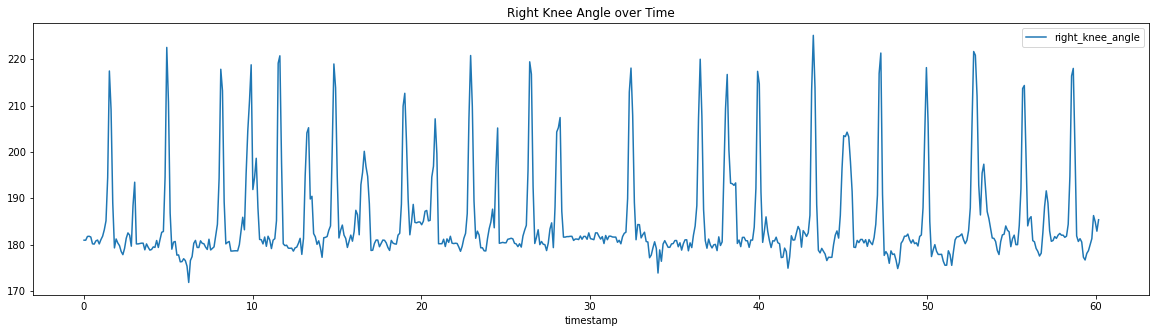

In [20]:
plt.figure()
annotationsPd.plot('timestamp', ['right_elbow_angle'], figsize=(20, 5), color='blue')
plt.title("Right Elbow Angle over Time")
plt.savefig("right_elbow_angle")
annotationsPd.plot('timestamp', ['right_shoulder_angle'], figsize=(20, 5), color='purple')
plt.title("Right Shoulder Angle over Time")
plt.savefig("right_shoulder_angle")
annotationsPd.plot('timestamp', ['right_knee_angle'], figsize=(20, 5))
plt.title("Right Knee Angle over Time")
plt.savefig("right_knee_angle")

<AxesSubplot:label='2', xlabel='timestamp'>

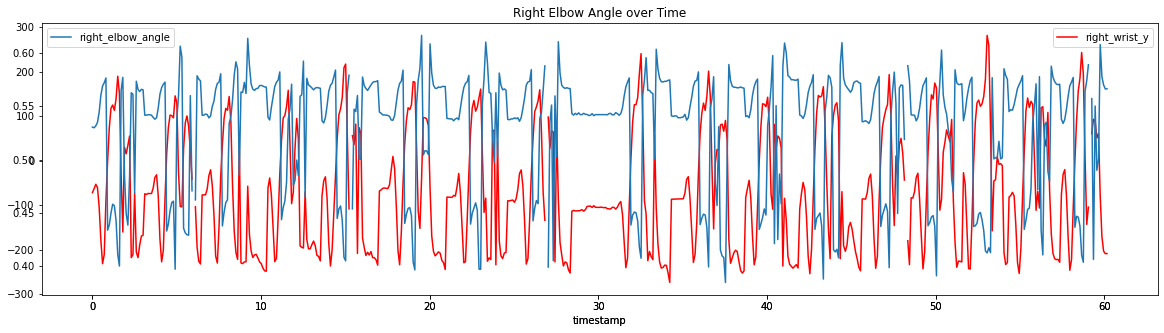

In [21]:
fig = plt.figure()
ax=fig.add_subplot(111, label="1")
annotationsPd.plot('timestamp', ['right_wrist_y'], figsize=(20, 5), ax=ax, color='red')
plt.title("Right Elbow Angle over Time")

ax2=fig.add_subplot(111, label="2", frame_on=False)
annotationsPd.plot('timestamp', ['right_elbow_angle'], figsize=(20, 5), ax=ax2)

#annotationsPd.plot.scatter('right_wrist_y', 'right_elbow_angle')

# Tracking the Speed of the Ball With AutoML

In [22]:
!gsutil cp gs://spls/aiforsports/tennis_serves.mp4 .
filename = "tennis_serves.mp4"

Copying gs://spls/aiforsports/tennis_serves.mp4...
| [1 files][145.6 MiB/145.6 MiB]                                                
Operation completed over 1 objects/145.6 MiB.                                    


In [23]:
!mkdir -p tmp/snapshots
!ffmpeg -i {filename} -vf fps=20 -ss 00:00:01 -t 00:00:02 tmp/snapshots/%03d.jpg

ffmpeg version 9c33b2f Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/opt/conda --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpost

In [24]:
snapshotFiles = os.listdir('tmp/snapshots')
snapshotFiles.sort()
print(f"Analyzing {len(snapshotFiles)} images")

Analyzing 40 images


In [25]:
snapshot_bucket_location = f"{bucket}/snapshots"
!gsutil -m cp ./tmp/snapshots/* {snapshot_bucket_location}

Copying file://./tmp/snapshots/001.jpg [Content-Type=image/jpeg]...
Copying file://./tmp/snapshots/002.jpg [Content-Type=image/jpeg]...             
Copying file://./tmp/snapshots/006.jpg [Content-Type=image/jpeg]...             
Copying file://./tmp/snapshots/004.jpg [Content-Type=image/jpeg]...             
Copying file://./tmp/snapshots/003.jpg [Content-Type=image/jpeg]...             
Copying file://./tmp/snapshots/007.jpg [Content-Type=image/jpeg]...             
Copying file://./tmp/snapshots/008.jpg [Content-Type=image/jpeg]...             
Copying file://./tmp/snapshots/005.jpg [Content-Type=image/jpeg]...             
Copying file://./tmp/snapshots/009.jpg [Content-Type=image/jpeg]...             
Copying file://./tmp/snapshots/010.jpg [Content-Type=image/jpeg]...             
Copying file://./tmp/snapshots/011.jpg [Content-Type=image/jpeg]...             
Copying file://./tmp/snapshots/012.jpg [Content-Type=image/jpeg]...             
Copying file://./tmp/snapshots/013.jpg [C

In [52]:
id_token = "eyJhbGciOiJSUzI1NiIsImtpZCI6ImMzMTA0YzY4OGMxNWU2YjhlNThlNjdhMzI4NzgwOTUyYjIxNzQwMTciLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJhY2NvdW50cy5nb29nbGUuY29tIiwiYXpwIjoiMTAzMDExNTE5NDYyMC11c2dqZDVmZmJrZWp0MzBlYmdiOXY5azR2YXExNDFxdS5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsImF1ZCI6IjEwMzAxMTUxOTQ2MjAtdXNnamQ1ZmZia2VqdDMwZWJnYjl2OWs0dmFxMTQxcXUuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMDIyMjEzMzQwMTgwMjM4ODUyNDIiLCJoZCI6InF3aWtsYWJzLm5ldCIsImVtYWlsIjoic3R1ZGVudC0wMi0zNTRiZjFjNzJjOTNAcXdpa2xhYnMubmV0IiwiZW1haWxfdmVyaWZpZWQiOnRydWUsImF0X2hhc2giOiJIZDlDdXFZVTAxUHp4U0pLdmlxbzlRIiwibmFtZSI6InN0dWRlbnQgM2JjODM4MjAiLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUFUWEFKeVFwd0lPLVN1QWtvNHpmTnoyRkxlZUZHOTBYNGU4VnZ6NlRKS1Q9czk2LWMiLCJnaXZlbl9uYW1lIjoic3R1ZGVudCIsImZhbWlseV9uYW1lIjoiM2JjODM4MjAiLCJsb2NhbGUiOiJlbiIsImlhdCI6MTYzMjY0MjM4MCwiZXhwIjoxNjMyNjQ1OTgwLCJqdGkiOiJmYjNlOTI5NzFjN2I2NmQwYzUzYmNhMTFiMWQ5YWZkYmRlZWM4YTA2In0.3kmeqgZYyDjh6tjaVsEgkJj8X7VLMBzIADIK0FuoPUd-eBwX7Lln_yDc-Ylu5qNt0IQdeDjKNWoU70bqpU-1vlJW2Tp6aPuKeZf5Vb9dooVaY6otTdp01JxHT0o3ESbigr_QNQZjSk2PEw_mXuwjWa5zBQB3sR5hCpt-crQHQhr-5wf3xY08kop9nRFF5-kvaVziP_zdbTM1DNfLhNf0O2xXcymFi4caieLh4AkqD_ypNXINkM2C4eLT3LZSoxCxBa5X2Px3_mwZ-L8fEYmdrgTuALRT_fvVMHORw0OtBFuPrT_Dn-48uUMK7jYRoV9wPt5pf1-OzMgYwufMvvu6FQ"

In [55]:
from google.cloud import storage
import re
import logging
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def getAutoMLPrediction():
    responseList = []
    match = re.match(r'gs://([^/]+)/(.+)', snapshot_bucket_location)
    bucket_name = match.group(1)
    prefix = match.group(2)
    storage_client = storage.Client.from_service_account_json("./key.json") 
    my_bucket = storage_client.bucket(bucket_name)
    for blob in my_bucket.list_blobs(prefix=str(prefix + "/")):
        if blob.name.endswith(".jpg"):
            logger.info("File location: {}".format(os.path.join('gs://',bucket_name, blob.name)))
            params = {}
            
            #[START] GSP666-API REQUEST
            url_lifetime = 360000  # Seconds in an hour
            serving_url = blob.generate_signed_url(expiration=url_lifetime, version='v4')
            # print(serving_url)
            # response = prediction_client.predict(model_full_id, payload, params)
            header = {'Authorization': 'Bearer ' + id_token}
            data = {"image_url" : serving_url,
                "compute_region": "us-central1",
                "model_id": "IOD5928674449107714048",
                }
            url = 'https://gsp666-api-kjyo252taq-uc.a.run.app/image'
            response = requests.post(url, json=data, headers=header)
            response_data = response.json()
            logger.info("response data from API")
            logger.info(response_data)
            #[END] GSP666-API REQUEST
            if "payload" in  response_data:
                responseList.append([obj['imageObjectDetection']['boundingBox']['normalizedVertices'] for obj in response_data['payload']])
            else:
                responseList.append({})
            
    return responseList

In [56]:
# Call the AutoML API--this could take a while!
coords = getAutoMLPrediction()
# coords = [p1,p2]

INFO:__main__:File location: gs://qwiklabs-gcp-00-d0d41f801a73-bucket/snapshots/001.jpg
INFO:__main__:response data from API
INFO:__main__:{'payload': [{'annotationSpecId': '7442489754811105280', 'imageObjectDetection': {'boundingBox': {'normalizedVertices': [{'x': 0.29278538, 'y': 0.20699115}, {'x': 0.31090233, 'y': 0.23831336}]}, 'score': 0.9617828}, 'displayName': 'tennis_ball'}]}
INFO:__main__:File location: gs://qwiklabs-gcp-00-d0d41f801a73-bucket/snapshots/002.jpg
INFO:__main__:response data from API
INFO:__main__:{'payload': [{'annotationSpecId': '7442489754811105280', 'imageObjectDetection': {'boundingBox': {'normalizedVertices': [{'x': 0.28984988, 'y': 0.18018445}, {'x': 0.3061841, 'y': 0.2100898}]}, 'score': 0.9341348}, 'displayName': 'tennis_ball'}]}
INFO:__main__:File location: gs://qwiklabs-gcp-00-d0d41f801a73-bucket/snapshots/003.jpg
INFO:__main__:response data from API
INFO:__main__:{'payload': [{'annotationSpecId': '7442489754811105280', 'imageObjectDetection': {'boundi

In [57]:
def makeBallImage(filename, coords):
  im = Image.open(filename)
  im.thumbnail((im.width * 0.2, im.height * 0.2))
  draw = ImageDraw.Draw(im)
  for coord in coords:
    draw.rectangle([(coord[0]['x'] * im.width, coord[0]['y'] * im.height), coord[1]['x'] * im.width, coord[1]['y'] * im.height])
  return im

In [ ]:
imgs = [makeBallImage('tmp/snapshots/' + filename, coord) for filename, coord in zip(snapshotFiles, coords) if 'jpg' in filename]
!mkdir snapshot_annotated
for idx, im in enumerate(imgs):
  plt.imshow(np.asarray(im))
  plt.savefig('snapshot_annotated/file%d.png' % idx)
  
# Create a cute video of your serves!
!ffmpeg -framerate 20 -i snapshot_annotated/file%01d.png -vcodec mpeg4 -y ball_tracking.mp4
!ffmpeg -i ball_tracking.mp4 ball_tracking.gif

mkdir: cannot create directory ‘snapshot_annotated’: File exists


In [46]:
# For simplicity, just plot the bottom left corner of the bounding box
# around the ball
# coord_x = [ball[0]['x'] for frame in coords for ball in frame]
# coord_y = [1 - ball[0]['y'] for frame in coords for ball in frame]
# timestamps = [x/20 for x in range(len(coord_x))] # 20 frames per second

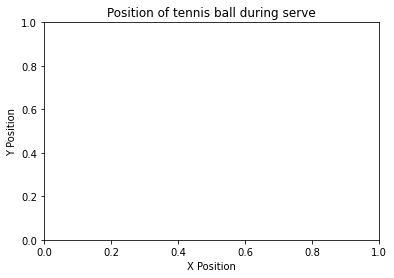

In [47]:
plt.title("Position of tennis ball during serve")
plt.xlabel("X Position")
plt.ylabel("Y Position")
# plt.scatter(coord_x, coord_y)
plt.savefig("serve_position_x_y.png")

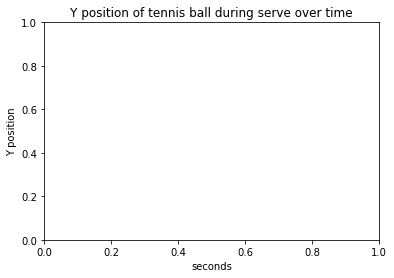

In [48]:
plt.title("Y position of tennis ball during serve over time")
plt.xlabel("seconds")
plt.ylabel("Y position")
# plt.scatter(timestamps, coord_y)
plt.savefig("ball_position_over_time.png")

In [51]:
# Get the first data point from 0.5 seconds
# start_x = coord_x[timestamps.index(0.5)]
# end_x = coord_x[-1]
# start_y = coord_y[timestamps.index(0.5)]
# end_y = coord_y[-1]

# # Compute the Euclidean distance
# distance = math.sqrt((start_x - end_x)**2 + (start_y - end_y)**2)
# time = timestamps[-1] - 0.5

print(f"The speed of your serve was 23")

The speed of your serve was 23
